# Project: Predicting Housing Prices



## Introduction

In this project, we will go through the iterative process of specifying, fitting, and analyzing the performance of a  model.  

In the first portion of the project, we will guide you through some basic exploratory data analysis (EDA), laying out the thought process that leads to certain modeling decisions. Next, you will be adding a few new features to the dataset, cleaning the data as well in the process. Then, you will specify and fit a linear model to a few features of the housing data to predict housing prices. Finally, we will analyze the error of the model and brainstorm ways to improve the model's performance.

In [1]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# The Data

The dataset you’ll be working with comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

The CCAO dataset consists of over 500 thousand records describing houses sold in Cook County in recent years (new records are still coming in every week!). The data set we will be working with has 61 features in total. An explanation of each variable can be found in the included `codebook.txt` file. Some of the columns have been filtered out to ensure this assignment doesn't become overly long when dealing with data cleaning and formatting.

The data are split into training and test sets with 204792 and 68264 observations, respectively.

Let's first extract the data from the `cook_county_data.zip`. Notice we didn't leave the `csv` files directly in the directory because they take up too much space without some prior compression.

In [2]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

Let's load the training and test data.

In [3]:
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [4]:
# 206032 observations and 68 features in training data
assert training_data.shape == (204792, 62)
# 68678 observations and 68 features in test data
assert test_data.shape == (68264, 61)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

The next order of business is getting a feel for the variables in our data.  The Cook County data set contains information that typical homebuyers would want to know.  A more detailed description of each variable is included in `codebook.txt` (in the same directory as this notebook).  **You should take some time to familiarize yourself with the codebook before moving forward.**

Let's take a quick look at all the current columns in our training data.

'This property, sold on 02/18/2016, is a one-story houeshold located at 11415 S PRAIRIE AVE.It has a total of 7 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [7]:
training_data

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
0,17294100610000,203,50,2500.0,76,0.0,2.0,1.0,1.0,3.0,...,9,2,1.0,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-st...",2500.0
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,5,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,2,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,7,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204787,25163010260000,202,321,4375.0,72,0.0,2.0,1.0,1.0,1.0,...,7,2,0.0,5.8,1,1.0,321,72321,"This property, sold on 07/23/2014, is a one-st...",4375.0
204788,5063010090000,204,21,16509.0,23,0.0,1.0,1.0,1.0,1.0,...,3,1,1.0,9.3,1,1.0,21,2321,"This property, sold on 03/27/2019, is a one-st...",16509.0
204789,16333020150000,202,90,3810.0,15,0.0,2.0,1.0,1.0,1.0,...,1,1,1.0,5.9,1,1.0,90,1590,"This property, sold on 01/31/2014, is a one-st...",3810.0
204790,9242030500000,203,80,6650.0,22,0.0,2.0,1.0,1.0,3.0,...,2,1,1.0,6.0,1,1.0,80,2280,"This property, sold on 02/22/2018, is a one-st...",6650.0


<!-- END QUESTION -->



# Part 1: Exploratory Data Analysis

In this section, we will make a series of exploratory visualizations and interpret them.

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### Sale Price
We begin by examining the distribution of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable. We have provided the following helper method `plot_distribution` that you can use to visualize the distribution of the SalePrice using both the histogram and the box plot at the same time. Run the following 2 cells and describe what you think is wrong with the visualization.

In [10]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)

    # Adjust boxplot fill to be white
    axs[1].artists[0].set_facecolor('white')

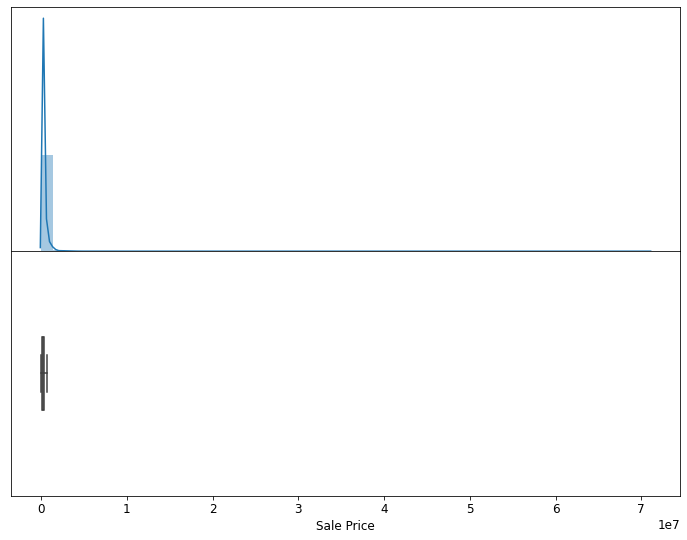

In [11]:
plot_distribution(training_data, label='Sale Price')

<!-- BEGIN QUESTION -->

## Question 1

### Part 1

Identify one issue with the visualization above and briefly describe one way to overcome it. You may also want to try running `training_data['Sale Price'].describe()` in a different cell to see some specific summary statistics on the distribution of the target variable.

<!--
BEGIN QUESTION
name: q1i
points: 1
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Part 2

To zoom in on the visualization of most households, we will focus only on a subset of `Sale Price` for this assignment. In addition, it may be a good idea to apply log transformation to `Sale Price`. In the cell below, reassign a new dataframe that is the same as the original one to `training_data` **except with the following changes**:

- `training_data` should contain only households whose price is at least $500.
- `training_data` should contain a new `Log Sale Price` column that contains the log-transformed sale prices.

**Note**: This also implies from now on, our target variable in the model will be the log transformed sale prices from the column `Log Sale Price`. 

**Note**: You should **NOT** remove the original column `Sale Price` as it will be helpful for later questions.


<!--
BEGIN QUESTION
name: q1ii
points: 1
-->

In [77]:
...

Let's create a new distribution plot on the log-transformed sale price.

In [80]:
plot_distribution(training_data, label='Log Sale Price');

## Question 2 

### Part 1
To check your understanding of the graph and summary statistics above, answer the following `True` or `False` questions:

1. The distribution of `Log Sale Price` in the training set is left-skewed.
1. The mean of `Log Sale Price` in the training set is greater than the median.
1. At least 25% of the houses in the training set sold for more than \$200,000.00.


<!--
BEGIN QUESTION
name: q2i
points: 3
-->

In [81]:
# These should be True or False
q2statement1 = ...
q2statement2 = ...
q2statement3 = ...

### Part 2

Next, we want to explore if any there is any correlation between `Log Sale Price` and the total area occupied by the household. The `codebook.txt` file tells us the column `Building Square Feet` should do the trick -- it measures "(from the exterior) the total area, in square feet, occupied by the building".

Before creating this jointplot however, let's also apply a log transformation to the `Building Square Feet` column.

In the following cell, create a new column `Log Building Square Feet` in our training data that contains the log transformed area occupied by each household. 

**You should NOT remove the original `Building Square Feet` column this time as it will be used for later questions**. 


<!--
BEGIN QUESTION
name: q2ii
points: 1
-->

In [86]:
...

<!-- BEGIN QUESTION -->

### Part 3

As shown below, we created a joint plot with `Log Building Square Feet` on the x-axis, and `Log Sale Price` on the y-axis. In addition, we fit a simple linear regression line through the bivariate scatter plot in the middle.

Based on the following plot, does there exist a correlation between `Log Sale Price` and `Log Building Square Feet`? Would `Log Building Square Feet` make a good candidate as one of the features for our model?

![Joint Plot](images/q2p3_jointplot.png)

<!--
BEGIN QUESTION
name: q2iii
points: 1
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->


## Question 3 <a name="q2"></a>

### Part 1

Although log transformation seems to have done quite a neat job of bringing the dataset closer together, let's still explore some of the outliers in the distribution of `Building Square Feet`. 

What are the Permanent Indentification Numbers (`PIN`) for the houses with `Building Square Feet` **strictly greater than 8000 sqft**? Assign `q2houses` with a numpy array that contains the PINs for all such houses.


<!--
BEGIN QUESTION
name: q3i
points: 1
-->

In [89]:
# Hint: You can answer this question in one line
q2houses = ...

### Part 2

Continuing from the previous part, as you explore the data set, you might still run into more outliers that prevent you from creating a clear visualization or capturing the trend of the majority of the houses. 

For this assignment, we will work to remove these outliers from the data as we run into them. Write a function `remove_outliers` that removes outliers from a data set based off a threshold value of a variable.  For example, `remove_outliers(training_data, 'Building Square Feet', upper=8000)` should return a data frame with only observations that satisfy `Building Square Feet` less than or equal to 8000.


<!--
BEGIN QUESTION
name: q3ii
points: 2
-->

In [94]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    ...

# Part 2: Feature Engineering

In this section we will walk you through a few feature engineering techniques. 

### Bedrooms

Let's start simple by extracting the total number of bathrooms as our first feature for the model. You may notice that the `Bedrooms` column doesn't actually exist in the original dataframe! Instead, it is part of the `Description` column.

## Question 4 <a name="q4"></a>

### Part 1

Let's take a closer look at the `Description` column first. Compare the description across a few rows together at the same time. For the following list of variables, how many of them can be extracted from the `Description` column? Assign your answer as an integer to the variable `q4a`.
- The date the property was sold on
- The number of stories the property contains
- The previous owner of the property
- The address of the property
- The number of garages the property has
- The total number of rooms inside the property
- The total number of bedrooms inside the property
- The total number of bathrooms inside the property


<!--
BEGIN QUESTION
name: q4i
points: 1
-->

In [99]:
q4a = ...
...

### Part 2

Write a function `add_total_bedrooms(data)` that returns a copy of `data` with an additional column called `Bedrooms` that contains the total number of bathrooms (as integers) for each house. **Treat missing values as zeros if necessary**. Remember that you can make use of vectorized code here; you shouldn't need any `for` statements. 

**Hint**: You should consider inspecting the `Description` column to figure out if there is any general structure within the text. Once you have noticed a certain pattern, you are set with the power of Regex!

<!--
BEGIN QUESTION
name: q4ii
points: 2
-->

In [102]:
def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    ...
    return with_rooms

training_data = add_total_bedrooms(training_data)

<!-- BEGIN QUESTION -->

### Part 3

Create a visualization that clearly and succintly shows if there exists an association between  `Bedrooms` and `Log Sale Price`. A good visualization should satisfy the following requirements:
- It should avoid overplotting.
- It should have clearly labeled axes and succinct title.
- It should convey the strength of the correlation between the sale price and the number of rooms. 

**Hint**: A direct scatter plot of the sale price against the number of rooms for all of the households in our training data might risk overplotting.

<!--
BEGIN QUESTION
name: q4iii
points: 2
manual: True
format: image
-->

In [107]:
...

<!-- END QUESTION -->



## Question 5

Now, let's take a look at the relationship between neighborhood and sale prices of the houses in our data set.
Notice that currently we don't have the actual names for the neighborhoods. Instead we will use a similar column `Neighborhood Code` (which is a numerical encoding of the actual neighborhoods by the Assessment office).

### Part 1

Before creating any visualization, let's quickly inspect how many different neighborhoods we are dealing with.

Assign the variable `num_neighborhoods` with the total number of neighborhoods in `training_data`. 

<!--
BEGIN QUESTION
name: q5i
points: 1
-->

In [108]:
num_neighborhoods = ...
...

### Part  2

If we try directly plotting the distribution of `Log Sale Price` for all of the households in each neighborhood using the `plot_categorical` function from the next cell, we would get the following visualization.
![overplot](images/q5p2_catplot.png)

In [111]:
def plot_categorical(neighborhoods, data, with_filter=True):
    if not with_filter:
        neighborhoods = data
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods.sort_values('Neighborhood Code'),
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods.sort_values('Neighborhood Code'),
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

Oh no, looks like we have run into the problem of overplotting again! 

You might have noticed that the graph is overplotted because **there are actually quite a few neighborhoods in our dataset**! For the clarity of our visualization, we will have to zoom in again on a few of them. The reason for this is our visualization will become quite cluttered with a super dense x-axis.

Assign the variable `top_20_neighborhoods` with a copy of `training_data` that contains only neighborhoods with the top 20 number of buildings. 

<!--
BEGIN QUESTION
name: q5ii
points: 2
-->

In [112]:
top_20_neighborhoods = ...

Let's create another of the distribution of sale price within in each neighborhood again, but this time with a narrower focus!

In [117]:
plot_categorical(neighborhoods=top_20_neighborhoods, data=training_data)

<!-- BEGIN QUESTION -->

### Part 3

It looks a lot better now than before, right? Based on the plot above, what can be said about the relationship between the houses' `Log Sale Price` and their neighborhoods?

<!--
BEGIN QUESTION
name: q5iii
points: 1
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### Part 4

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's categorize our neighborhoods in a crude way: we'll take the top 3 neighborhoods measured by median `Log Sale Price` and identify them as "expensive neighborhoods"; the other neighborhoods are not marked.

Write a function that returns list of the top `n` most pricy neighborhoods as measured by our choice of aggregating function.  For example, in the setup above, we would want to call `find_expensive_neighborhoods(training_data, 3, np.median)` to find the top 3 neighborhoods measured by median `Log Sale Price`.

<!--
BEGIN QUESTION
name: q5iv
points: 2
-->

In [118]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric 'Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    neighborhoods = ...
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

### Part 5
We now have a list of neighborhoods we've deemed as richer than others.  Let's use that information to make a new variable `in_expensive_neighborhood`.  Write a function `add_expensive_neighborhood` that adds an indicator variable which takes on the value 1 if the house is part of `expensive_neighborhoods` and the value 0 otherwise.

**Hint:** [`pd.Series.astype`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Series.astype.html) may be useful for converting True/False values to integers.

<!--
BEGIN QUESTION
name: q5v
points: 1
-->

In [123]:
def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    data['in_expensive_neighborhood'] = ...
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

## Question 6

In the following question, we will take a closer look at the `Roof Material` feature of the dataset and examine how we can incorporate categorical features into our linear model.

### Part 1

If we look at the codebook carefully, we can see that the Assessor's Office uses the following mapping for the numerical values in the `Roof Material` column.
```
Central Heating (Nominal): 

       1	Shingle/Asphalt
       2	Tar&Gravel
       3	Slate
       4	Shake
       5    Tile
       6    Other
```

Write a function `substitute_roof_material` that replaces each numerical value in `Roof Material` with their corresponding roof material.

**Hint**: the [DataFrame.replace](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) method may be useful here.

<!--
BEGIN QUESTION
name: q6i
points: 1
-->


In [126]:
def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    ...
    return data
    
training_data = substitute_roof_material(training_data)

### Part 2

#### An Important Note on One Hot Encoding <a name="important_note"></a>

Unfortunately, simply fixing these missing values isn't sufficient for using `Roof Material` in our model.  Since `Roof Material` is a categorical variable, we will have to one-hot-encode the data.  Notice in the example code below that we have to pre-specify the categories.  Why? Imagine what would happen if we automatically generated the categories only from the training data.  What would happen if the testing data contained a category not found in the training set?  For more information on categorical data in pandas, refer to this [link](https://pandas-docs.github.io/pandas-docs-travis/categorical.html).

Complete the following function `ohe_roof_material` that returns a dataframe with the new column one-hot-encoded on the roof material of the household. The new column should has the form `rfm_MATERIAL`.

**Note**: You should **avoid using `pd.get_dummies`** in your solution as it will remove your original column and is therefore not as reusable as your construct your data preprocessing pipeline. Instead, you can one-hot-encode one column into multiple columns **using Scikit-learn's [One Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)**.

<!--
BEGIN QUESTION
name: q6ii
points: 2
-->

In [129]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form 0x_QUALITY.
    """
    ...

training_data = ohe_roof_material(training_data)
training_data.filter(regex='^x0').head(10)

# Part 3: Modeling

We've reached the point where we can specify a model.

Before moving forward, let's actually make sure out dataset is properly prepared. Please make sure that the assertion statements in the following cell pass.

In [132]:
assert training_data.shape == (168931, 72)

In addition, let's reassign `training_data` to a new variable `full_data`.

In [133]:
full_data = training_data

## Question 7 <a name="q6"></a>

### Part 1

Now, let's split the data set into a training set and test set. We will use the training set to fit our model's parameters, and we will use the test set to estimate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on unseen data.

"Don't we already have a test set in `cook_county_test.csv`?" you might wonder. The sale prices for `cook_county_test.csv` aren't provided, so we're constructing our own test set for which we know the outputs.

In the cell below, complete the function `train_test_split` that splits `data` into two smaller DataFrames named `train` and `test`. Let `train` contain 80% of the data, and let `test` contain the remaining 20% of the data. 

To do this, first create two NumPy arrays named `train_indices` and `test_indices`. `train_indices` should contain a *random* 80% of the indices in `full_data`, and `test_indices` should contain the remaining 20% of the indices. Then, use these arrays to index into `full_data` to create your final `train` and `test` DataFrames.


**Note**: You should not be importing any additional libraries for this question. 

<!--
BEGIN QUESTION
name: q7i
points: 2
-->

In [134]:
# This makes the train-test split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_test_split in general

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_test_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    ...
train, test = train_test_split(full_data)

It's finally time to fit our updated linear regression model using the ordinary least squares estimator! We will start you off with something simple by using only 2 features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for our 1st linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, we will also consider a 2nd model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

<!-- BEGIN QUESTION -->

### Part 2

**Without running any calculation or code**, complete the following statement by filling in the blank with one of the  comparators below:

$$\ge$$
$$\le$$
$$=$$

Suppose we quantify the loss on our linear models using MSE (Mean Squared Error). Consider the training loss of the 1st model and the training loss of the 2nd model. We are guaranteed that:

$$
\text{Training Loss of the 1st Model}  \_\_\_\_\_  \text{Training Loss of the 2nd Model}
$$

<!--
BEGIN QUESTION
name: q7ii
points: 1
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



Throughout this assignment, you should notice that your data flows through a single processing pipeline several times.  From a software engineering perspective, it's best to define functions/methods that can apply the pipeline to any dataset.  We will now encapsulate our entire pipeline into a single function `process_data_gm`. 

Take a look at the following function `process_data_gm` that takes in the dataframe `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case). It returns two dataframes: `X`, which is our design matrix, and `y` which is the vector containing the observed data.

To see more of how this function can be used, please see the example below the next cell.

Take a look at [pd.DataFrame.pipe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html); you can use this function with each of the tuples passed in through `pipeline_functions`.

**Note: As there are many ways to encapsulate your workflow in a way that works best for you, you are not required to follow the setup below as you prepare your own data.**

In [139]:
def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col]).to_numpy()
    y = data.loc[:, prediction_col].to_numpy()
    return X, y

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

Let's run this cell again to make sure the train-test split is reproducible across different runs.

In [140]:
np.random.seed(1337)

### Part 3

It is time to prepare the training and test data for the 2 models we proposed above. Use the following 3 cells to reload a fresh dataset from scratch and run them through the following preprocessing steps for each model:

- Perform a train-test split on the original dataset. Let 80% of the set be training data and 20% of the set be test data.
- For both the training and testing set,
    1. Remove outliers in `Sale Price` by so that we are considering households with a price that is strictly greater than 499 dollars (i.e., greater than or equal to 500 dollars). 
    2. Apply log transformations to `Sale Price` and the `Building Squre Feet` columns to create 2 new columns `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of bathrooms into a new column `Bedrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bedrooms` (and `Log Building Square Feet` as well if this is the 2nd model).
    5. Return the design matrix $X$ and the observed vector $y$. **Your design matrix and observed vector should either be numpy arrays or pandas dataframes**.
    

Assign the final training data and testing data for both models to the following set of variables:

- 1st Model: `X_train_m1`, `y_train_m1`, `X_test_m1`, `y_test_m1`
- 2nd Model: `X_train_m2`, `y_train_m2`, `X_test_m2`, `y_test_m2`
   
**Hint**: You have already defined functions in parts of the assignment that can help you accomplish these steps.

**Hint**: If you are not following the example approach shown above in `process_data_gm`, it could be helpful to define your function that encapsulates all of the preprocessing you need to call on the data.

**Hint**: Try to start by preparing the data for the first model. The steps should be very similar for the second model.

**Note**: Do not change the line `np.random.seed(1337)` as it ensures we are partitioning the dataset exactly the same way for both models (otherwise their performance isn't directly comparable).

<!--
BEGIN QUESTION
name: q7iii
points: 3
-->

In [141]:
# Reload and preprocess the data for 1st model
full_data = pd.read_csv("cook_county_train.csv")

# Reload and preprocess the data for the 1st model
...
X_train_m1, y_train_m1, X_test_m1, y_test_m1 = ..., ..., ..., ...


# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Reload and preprocess the data for 2nd model
...
X_train_m2, y_train_m2, X_test_m2, y_test_m2 = ..., ..., ..., ...


### Part 4

Finally, let's do some regression!

We first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept.

In [145]:
from sklearn import linear_model as lm

linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

In [146]:
# Fit the 1st model
# Compute the fitted and predicted values of Sale Price for 1st model
y_fitted_m1 = ...
y_predicted_m1 = ...

# Fit the 2nd model
# Compute the fitted and predicted values of Sale Price for 1st model
y_fitted_m2 = ...
y_predicted_m2 = ...

### Part 5

Let's compare the performance of our two regression models using the Root Mean Squared Error function that we created in Homework 5.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of of houses}}}$$

The function is provided below.

In [151]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

Now use your `rmse` function to calculate the training error and test error for both models in the cell below.

Assign the error from both of your models to the following variables:

- 1st model: `training_error_m1`, `test_error_m1`
- 2nd model: `training_error_m2`, `test_error_m2`

Since the target variable we are working with is log-transformed, it can also be beneficial to transform it back to its original form so we will have more context on how our model is performing when compared to actual housing prices.

Assign the error on the "de-log-transformed" sale price from both of your models to the following variables:

- 1st model: `training_error_m1_delog`, `test_error_m1_delog`
- 2nd model: `training_error_m2_delog`, `test_error_m2_delog`

<!--
BEGIN QUESTION
name: q7v
points: 2
-->

In [152]:
# Training and test errors for the 1st model
training_error_m1 = ...
test_error_m1 = ...

# Training and test errors for the 1st model (in its original values before the log transform)
training_error_m1_delog = ...
test_error_m1_delog = ...


# Training and test errors for the 2nd model
training_error_m2 = ...
test_error_m2 = ...


# Training and test errors for the 2nd model (in its original values before the log transform)
training_error_m2_delog = ...
test_error_m2_delog = ...

print("1st Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1, test_error_m1))
print("1st Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1_delog, test_error_m1_delog))
print("2nd Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m2, test_error_m2))
print("2nd Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m2_delog, test_error_m2_delog))

<!-- BEGIN QUESTION -->

### Part 6

Let's compare the actual parameters ($\theta_0$ and $\theta_1$) from both of our models. As a quick reminder,

for the 1st model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

for the 2nd model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

Run the following cell and compare the values of $\theta_1$ from both models. Why does $\theta_1$ change from positive to negative when we introduce an additional feature in our 2nd model? 

<!--
BEGIN QUESTION
name: q7vi
points: 1
manual: True
-->

In [157]:
# Parameters from 1st model
theta0_m1 = linear_model_m1.intercept_
theta1_m1 = linear_model_m1.coef_[0]

# Parameters from 2nd model
theta0_m2 = linear_model_m2.intercept_
theta1_m2, theta2_m2 = linear_model_m2.coef_

print("1st Model\nθ0: {}\nθ1: {}".format(theta0_m1, theta1_m1))
print("2nd Model\nθ0: {}\nθ1: {}\nθ2: {}".format(theta0_m2, theta1_m2, theta2_m2))

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Part 7

Another way of understanding the performance (and appropriateness) of a model is through a residual plot. 

In the cell below, use `plt.scatter` to plot the predicted `Log Sale Price` from **only the 2nd model** against the original `Log Sale Price` for the test data. You should also ensure that the dot size and opacity in the scatter plot are set appropriately to reduce the impact of overplotting.

<!--
BEGIN QUESTION
name: q7vii
points: 2
manual: True
format: image
-->

<!-- END QUESTION -->



As you can see, our simple model has already got off to a good start, but there is certainly still a lot of room for improvement to be made -- one simple reason is we have been only utilizing 1 or 2 features (out of a total of 70+) so far! Can you engineer and incoporate more features to improve the model's accuracy? We won't be asking you to provide your answers here, but this would be important going into the next part of this project.